In [2]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa

import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  /Users/adelehannotte/Pypsa-earth/pypsa-earth
Had to go 1 folder(s) up.


In [3]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

In [4]:
solved_37_network = os.getcwd() +  "/results/networks/elec_s_37_ec_lcopt_Co2L-3H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve_37 = pypsa.Network(solved_37_network)


INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
elec_network= os.getcwd() +  "/networks/elec.nc"

n_elec= pypsa.Network(elec_network)

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


In [6]:
n=n_solve_37

# Plot OSM network

In [7]:

def calculate_width_height_image(
    width_image, height_image, max_width=max_width_image, max_height=max_height_image
):
    """
    Function to identify the width and height of an image to plot
    while keeping the proportions of the image
    """
    if width_image / height_image >= max_width / max_height:
        # image width is the limiting factor
        return (max_width, max_width / width_image * height_image)
    else:
        # image height is the limiting factor
        return (max_height / height_image * width_image, max_height)

NameError: name 'max_width_image' is not defined

In [ ]:
import matplotlib

# Paths of build shape
# path of the gadm shapes
path_gadm_shapes = "resources/shapes/gadm_shapes.geojson"

# Path of the OSM data
# raw OSM substation data
path_raw_substations = "resources/osm/raw/all_raw_substations.geojson"
# raw OSM lines data
path_raw_lines = "resources/osm/raw/all_raw_lines.geojson"

# network paths
path_cluster_network = "networks/elec_s_37.nc"
# solve network output
solved_network_path = "results/networks/elec_s_37_ec_lcopt_Co2L-3H.nc"

# Images setups
max_width_image = 30
max_height_image = 30
dpi = 300

# gadm file imports
countries = shapes
gadm = gpd.read_file(path_gadm_shapes)

# OSM data imports
df_substations_osm_raw = gpd.read_file(path_raw_substations)
df_lines_osm_raw = gpd.read_file(path_raw_lines)

# network imports
# cluster network
n_c = pypsa.Network(path_cluster_network)
# solved network
n_solve = pypsa.Network(solved_network_path)

total_bounds_countries = countries.total_bounds
delta_bounds_xy = (
    total_bounds_countries[2] - total_bounds_countries[0],  # maxx - minx
    total_bounds_countries[3] - total_bounds_countries[1],
)  # maxy - miny

size_image = calculate_width_height_image(*delta_bounds_xy)

ax2 = gadm.plot(
    figsize=size_image,
    column="pop",
    cmap="OrRd",
    legend=True,
    label=None,
    norm=matplotlib.colors.LogNorm(
        vmin=gadm["pop"].min() + 1, vmax=gadm["pop"].max(), clip=True
    ),
    legend_kwds={"extend": "max", "label": "Population in administrative zones [#]"},
)  # column="pop",
df_lines_osm_raw.plot(ax=ax2, color="black", label="OSM lines", linewidth=4)
df_substations_osm_raw.plot(
    ax=ax2, color="grey", label="OSM substations", alpha=0.7, markersize=40
)

legend = plt.legend(
    frameon=1, loc="lower center", labelcolor="white", facecolor="tab:blue"
)

plt.axis("off")
plt.savefig("continent_image.png", dpi=dpi, bbox_inches="tight")

In [ ]:
ax = countries.boundary.plot(figsize=(10, 10), color="red")
# off_shore.plot(ax=ax)
df_substations_osm_raw.plot(ax=ax, color="blue")
df_lines_osm_raw.plot(ax=ax, color="orange")
plt.axis("off")
plt.savefig("border_osm_total.png", dpi=dpi)

# Plot locational marginal price

In [ ]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))

plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

# Netwotk statistics


It is possible to get direct analysis values of the network and plot them, including Capacity Factor, Capital Expenditure, Curtailment, Installed Capacity, Operational Expenditure, Optimal Capacity, Revenue, Supply and Withdrawal

In [ ]:
n.statistics()

<AxesSubplot:xlabel='carrier', ylabel='Euros'>

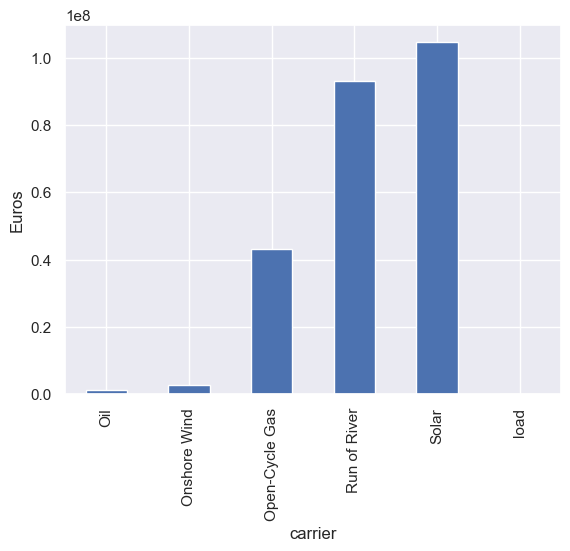

In [8]:
n.statistics()["Capital Expenditure"].loc["Generator"].plot.bar(ylabel="Euros")

# Nice map energy source

In [9]:
elec_network= os.getcwd() +  "/networks/elec.nc"
n_elec= pypsa.Network(elec_network)

n = n_elec
regions_onshore = gpd.read_file(f"resources/bus_regions/regions_onshore_elec_s_37.geojson")


INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


(<matplotlib.collections.PatchCollection at 0x170208d90>,
 <matplotlib.collections.LineCollection at 0x170175690>)

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


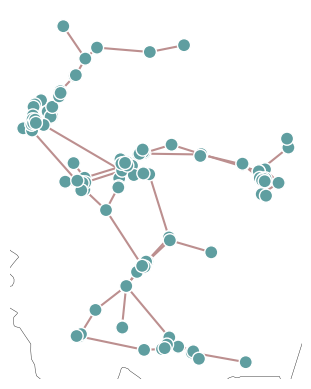

In [10]:
n.plot()

In [170]:
gen = n.generators.groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

bus_scale = 3e3 
line_scale = 1e3

In [171]:
n.generators['p_nom'].max()

315.56172775777736

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


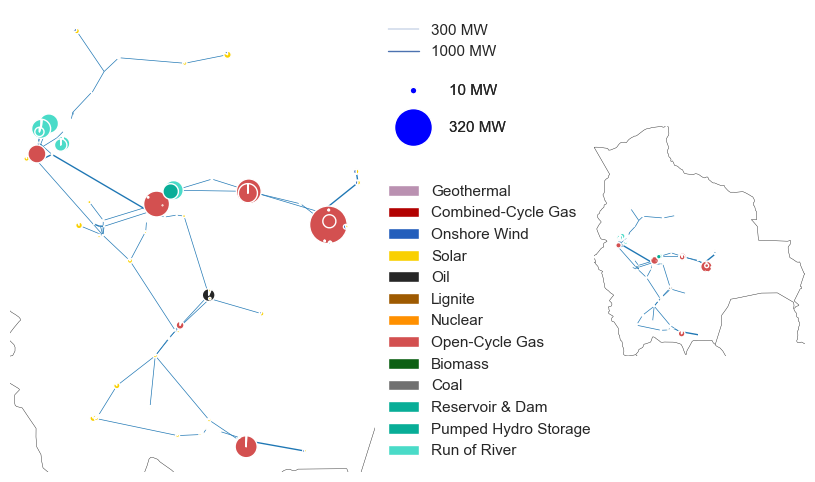

In [172]:
# create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree()},gridspec_kw={"width_ratios": [3, 1]})
# plot your network in the first subplot

n.plot(ax=ax2,
       bus_sizes=buses / bus_scale,
       line_widths=n.lines.s_nom / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors="tab:blue")
#ax2.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
ax2.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


# second subplot
n.plot(ax=ax1, 
       bus_sizes=buses / bus_scale,
       line_widths=n.lines.s_nom / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors="tab:blue")

legend_kwargs = {"loc": "upper left", "frameon": False}

add_legend_patches(
    ax1,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)

line_sizes = [300, 1000]  # in MW
add_legend_lines(
    ax1,
    [s / line_scale for s in line_sizes],
    [f"{s} MW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 1), **legend_kwargs},
)

legend_circles_dict = {"bbox_to_anchor": (1.05, 0.87), "labelspacing": 1.5, **legend_kwargs}
bus_sizes = [10, 320]  # in MW
add_legend_circles(
    ax1,
    [s / bus_scale for s in bus_sizes],
    [f"{s} MW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)

image_format = 'eps' # e.g .png, .svg, etc.

fig.savefig('distribution_source_run1.eps', format=image_format, dpi=1200)
# show the subplots
plt.show()

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


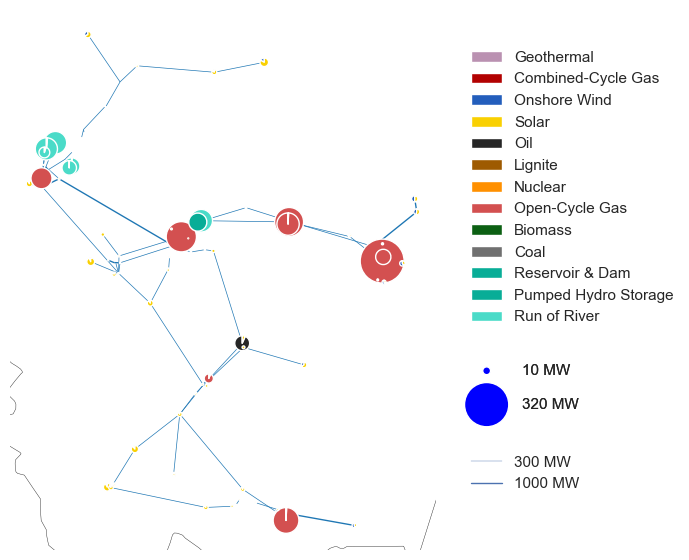

In [179]:
import matplotlib.pyplot as plt

# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={"projection":ccrs.PlateCarree()})

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.05, 0.05, 0.6, 0.9])

# plot your network on the left side of the subplot
n.plot(ax=ax, 
       bus_sizes=buses / bus_scale,
       line_widths=n.lines.s_nom / line_scale,
       link_widths=n.links.p_nom / line_scale,
       line_colors="tab:blue")

# add a legend to the plot
legend_kwargs = {"loc": "upper left", "frameon": False}
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1.05, 0.95), **legend_kwargs},
)
line_sizes = [300, 1000]  # in MW
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s} MW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1.05, 0.2), **legend_kwargs},
)
legend_circles_dict = {"bbox_to_anchor": (1.07, 0.37), "labelspacing": 1.3, **legend_kwargs}
bus_sizes = [10, 320]  # in MW
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s} MW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
)

# save the plot
image_format = 'eps' # e.g .png, .svg, etc.
fig.savefig('distribution_source_run1_good.eps', format=image_format, dpi=1200)

# show the plot
plt.show()